In [17]:
import json
import time
import boto3

textract_client = boto3.client('textract')

In [18]:
!pip3 install -q textract-trp 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [19]:
import trp
import os
import pandas as pd

In [4]:
os.chdir('..')
os.listdir('.')

['Notebooks', 'ConvertedImages', '.ipynb_checkpoints']

In [20]:
document_s3_path='s3://client-brad/client-tony/doc_type_2.pdf'

In [21]:
bucket='client-brad'
document='client-tony/doc_type_2.pdf'

In [22]:
response = textract_client.start_document_analysis(DocumentLocation={'S3Object': {'Bucket': bucket, 'Name': document}},
                FeatureTypes=["TABLES","FORMS"])

In [23]:
jobid=response['JobId']
jobid

'61a31137a3a1bc0ef4d71efc7497f7ff676139cf7f272ca6bc33d148240cf515'

In [24]:
response = textract_client.get_document_analysis(JobId=jobid)
#                        MaxResults=maxResults)

In [ ]:
response['Blocks'][0].keys()

In [25]:

pages = []
table_blocks =[]
csv =''
blocks=[]

def getJobResults(jobId):
    
    global textract_client
    global pages
    global table_blocks
    global blocks
    

    time.sleep(2)
    response = textract_client.get_document_analysis(JobId=jobId)
    pages.append(response)
    print("Resultset page recieved: {}".format(len(pages)))
    nextToken = None                                                # quando tem mais de um lote de retorno, a amazon cria uma sub id unica do próximo lote armazenada 'NextToken' do lote atual
    if('NextToken' in response):
        nextToken = response['NextToken']
    while(nextToken):
        time.sleep(5)
        response = textract_client.get_document_analysis(JobId=jobId, NextToken=nextToken)
        
        pages.append(response)                                                                  # vai guardando todos os lotes na lista pages
        print("Resultset page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            nextToken = response['NextToken']
    return pages

In [26]:
aa=getJobResults(jobid)

Resultset page recieved: 1
Resultset page recieved: 2
Resultset page recieved: 3


In [27]:
aa[0]['Blocks'][10].keys()

dict_keys(['BlockType', 'Confidence', 'Text', 'Geometry', 'Id', 'Relationships', 'Page'])

In [28]:
def get_rows_columns_map(table_result, blocks_map):
    rows = {}
    for relationship in table_result['Relationships']:
        if relationship['Type'] == 'CHILD':
            for child_id in relationship['Ids']:
                cell = blocks_map[child_id]
                if cell['BlockType'] == 'CELL':
                    row_index = cell['RowIndex']
                    col_index = cell['ColumnIndex']
                    if row_index not in rows:
                        # create new row
                        rows[row_index] = {}
                        
                    # get the text value
                    rows[row_index][col_index] = get_text(cell, blocks_map)  #4
    #print(rows)
    return rows


def get_text(result, blocks_map):
    text = ''
    if 'Relationships' in result:
        for relationship in result['Relationships']:
            if relationship['Type'] == 'CHILD':
                for child_id in relationship['Ids']:
                    word = blocks_map[child_id]
                    if word['BlockType'] == 'WORD':
                        text += word['Text'] + ' '
                    if word['BlockType'] == 'SELECTION_ELEMENT':
                        if word['SelectionStatus'] =='SELECTED':
                            text +=  'X '    
    return text



In [29]:
def generate_table_csv(table_result, blocks_map, table_index):
    rows = get_rows_columns_map(table_result, blocks_map)
    print(rows)
    table_id = 'Table_' + str(table_index)
    
    # get cells.
    csv = 'Table: {0}\n\n'.format(table_id)

    for row_index, cols in rows.items():
        
        for col_index, text in cols.items():
            csv += '{}'.format(text) + "&&"  ## Se quiser modificar o delimiter tem de ser aqui, antes era "," - agora é "&&"; fiz isso porque no Brasil nossa separação decimal é vírgula e conflitos apareciam qdo extrair tabelas envolvendo valores monetários...
        csv += '\n'
        
    csv += '\n\n\n'
    return csv

In [30]:
contador=0
csv = ''
blocks=[]
for item in pages:
  blocks= blocks + pages[contador]['Blocks']                                                # esse é o ponto crucial para qdo houver mais de um lote; vc precisa somar todos os ['Blocks'] na lista blocks, do contrário qdo for reconstruir as tabelas vai ter um erro de Key (parte das informações estão podem estar em lotes diferentes)
  contador= contador+1
print(contador)

blocks_map = {}
table_blocks = []
for block in blocks:
    blocks_map[block['Id']] = block
    if block['BlockType'] == "TABLE":
      table_blocks.append(block)


if len(table_blocks) <= 0:
    print( "<b> NO Table FOUND </b>")


for index, table in enumerate(table_blocks):
    csv += generate_table_csv(table, blocks_map, index +1)
    csv += '\n\n'



3
{1: {1: 'YEAR TAXING ENTITIES ', 2: 'EXEMPTIONS ', 3: 'TAXABLE ', 4: 'TAX RATE ', 5: 'TAX AMT ', 6: 'TAX DUE ', 7: '*ADDN FEES ', 8: 'TOTAL DUE '}, 2: {1: '2020 01H HOWARD COUNTY ', 2: '0 ', 3: '189,934,360 ', 4: '299562 ', 5: '568,971.17 ', 6: '568,971.17 ', 7: '0.00 ', 8: '568,971.17 '}, 3: {1: '2020 03B BIG SPRING ISD ', 2: '0 ', 3: '189,934,360 ', 4: '1.116400 ', 5: '2,120,427.20 ', 6: '2,120,427.20 ', 7: '0.00 ', 8: '2,120,427.20 '}, 4: {1: '2020 049 PERMIAN BASIN UWCD ', 2: '0 ', 3: '189,934,360 ', 4: '.003445 ', 5: '6,543.24 ', 6: '6,543.24 ', 7: '0.00 ', 8: '6,543.24 '}, 5: {1: '2020 052 HOWARD COLLEGE ', 2: '0 ', 3: '189,934,366 ', 4: '216675 ', 5: '411,540.27 ', 6: '411,540.27 ', 7: '0.00 ', 8: '411,540.27 '}, 6: {1: '', 2: '', 3: '', 4: '', 5: '', 6: '$3,107,481. ', 7: '$0.00 ', 8: '$3,107,481.88 '}}
{1: {1: 'GEOID: 00062475020502 ', 2: '', 3: '', 4: '', 5: '', 6: '', 7: 'ASSESSED ', 8: '1,500,000 '}, 2: {1: 'YEAR TAXING ENTITIES ', 2: 'EXEMPTIONS ', 3: 'TAXABLE ', 4: 'TAX

In [31]:
csv

'Table: Table_1\n\nYEAR TAXING ENTITIES &&EXEMPTIONS &&TAXABLE &&TAX RATE &&TAX AMT &&TAX DUE &&*ADDN FEES &&TOTAL DUE &&\n2020 01H HOWARD COUNTY &&0 &&189,934,360 &&299562 &&568,971.17 &&568,971.17 &&0.00 &&568,971.17 &&\n2020 03B BIG SPRING ISD &&0 &&189,934,360 &&1.116400 &&2,120,427.20 &&2,120,427.20 &&0.00 &&2,120,427.20 &&\n2020 049 PERMIAN BASIN UWCD &&0 &&189,934,360 &&.003445 &&6,543.24 &&6,543.24 &&0.00 &&6,543.24 &&\n2020 052 HOWARD COLLEGE &&0 &&189,934,366 &&216675 &&411,540.27 &&411,540.27 &&0.00 &&411,540.27 &&\n&&&&&&&&&&$3,107,481. &&$0.00 &&$3,107,481.88 &&\n\n\n\n\n\nTable: Table_2\n\nGEOID: 00062475020502 &&&&&&&&&&&&ASSESSED &&1,500,000 &&\nYEAR TAXING ENTITIES &&EXEMPTIONS &&TAXABLE &&TAX RATE &&TAX AMT &&TAX DUE &&*ADDN FEES &&TOTAL DUE &&\n2020 01H HOWARD COUNTY &&0 &&1,500,000 &&299562 &&4,493.43 &&4,493.43 &&0.00 &&4,493.43 &&\n2020 03B BIG SPRING ISD &&0 &&1,500,000 &&1.116400 &&16,746.00 &&16,746.00 &&0.00 &&16,746.00 &&\n2020 049 PERMIAN BASIN UWCD &&0 &&1,

## Plotting bbxes on words

In [65]:
    
def parsing_the_textract_DetectDocumentText_response(response):
    
    output_dict={}
    data_list=response['Blocks']
    for index,value in enumerate(data_list):
        if value['BlockType']=='WORD':
            text=value['Text']
            confidence=value['Confidence']
            width=value['Geometry']['BoundingBox']['Width']
            height=value['Geometry']['BoundingBox']['Height']
            top=value['Geometry']['BoundingBox']['Top']
            left=value['Geometry']['BoundingBox']['Left']
            output_dict[text]=[confidence,width,height,top,left]
    return output_dict


In [67]:
def plotting_coordinates_from_response(image_size,width,height,top,left):
    
    page_width=image_size[0]
    page_height=image_size[1]
    X=page_width*left
    Y=page_height*(height+top)-55  # I donot know but the bounding boxes are deviated by 50 in height
    xy_coordinate=(X,Y)
    word_width=page_width*width
    word_height=page_height*height
    
    return xy_coordinate,word_width,word_height


In [ ]:
out=parsing_the_textract_DetectDocumentText_response(aa[0])
#out


In [77]:
out2=parsing_the_textract_DetectDocumentText_response(aa[1])
#out


In [80]:
out3=parsing_the_textract_DetectDocumentText_response(aa[2])
#out


In [81]:
len(out2),len(out),len(out3)

(312, 303, 98)

In [76]:
len(out)

303

In [86]:
out2.keys()

dict_keys(['2017', 'APPRAISED', 'VALUE', '1,500,000', '2018', '1,', ',500,000', '2019', 'ENTITY', 'TAXABLE', 'RATE', 'TAX', '%CHG', '01H', '2000000', '0.3718', '7437.70', '23.67', '1750000', '0.4400', '7700.00', '3.526', '1500000', '6600.00', '-14.2', '0.3280', '4920.36', '-25.4', '0.3031', '4547.48', '-7.57', '03B', '1.4195', '28390.00', '4.336', '1.3995', '24491.25', '-13.7', '20992.50', '1.2400', '18600.00', '-11.3', '1.1200', '16800.00', '-9.67', '049', '0.0068', '137.08', '22.38', '0.0088', '154.72', '12.86', '0.0079', '119.25', '-22.9', '0.0064', '96.16', '-19.3', '0.0035', '52.50 -45.4', '052', '0.2516', '5032.46', '42.46', '0.3137', '5491.46', '9.120', '0.3142', '4714.28', '-14.1', '0.2323', '3484.74', '-26.0', '0.2106', '3159.56-9.33', '1/3', '2/3', 'PROPERTY', 'IDENTIFICATION', '(3)', 'LEGAL', 'DESCRIPTION', 'VALUATION', 'SUMMARY', 'PROP', 'ID:', 'I000041322', 'INVENTORY', 'PERSONAL', '4,500,000', 'ASSESSED', 'GEOID:', '00062475000500', 'YEAR', 'TAXING', 'ENTITIES', 'EXEMPTIO

In [87]:
out3.keys()

dict_keys(['REFLECTS', 'PROPERTY', 'TAX', 'OF', '3', 'PROPERTIES', 'FOR', 'RETURN', 'RECEIPT', 'ENCLOSE', 'A', 'SELF', 'ADDRESSED', 'STAMPED', 'ENVELOPE.', 'PLEASE', 'BOTTOM', 'PORTION', 'WITH', 'PAYMENT.', 'CHECK', 'IF', 'INFORMATION', 'BELOW', 'HAS', 'CHANGED', 'PAID', 'IN', '*ADDN', 'FEES', 'AMOUNT', 'DUE', 'PAYMENT', 'RECEIVED', '-', '>', 'OCT', '2020', '0.00', 'ALON', 'USA', 'LP', '(PLANT)', '3,205,646.80', 'NOV', '%', 'DEPT', 'DEC', '7102', 'COMMERCE', 'WAY', 'JAN', '2021', 'BRENTWOOD,', 'TN', '37027', 'AGT :', '040', 'K', 'E', 'ANDREWS', '&', 'COMPANY', 'FEB', '224,395.28', '3,430,042.08', 'MAR', '288,508.21', '3,494,155.01', 'MAKE', 'PAYABLE', 'AND', 'REMIT', 'TO', 'TOTAL', 'ENCLOSED', '$', 'HOWARD', 'COUNTY', 'OFFICE', 'TIFFANY', 'SAYLES', 'TAC', 'P.O.', 'BOX', '1111', '315', 'SOUTH', 'MAIN', 'BIG', 'SPRING,', 'TX', '79720-1111', '$I41322', '10/9/2020', 'USE', 'ONLY', '3/3'])

In [ ]:
plotting_coordinates_dict={}
for key in out.keys():
    
    res=plotting_coordinates_from_response((1152,864),out[key][1],out[key][2],out[key][3],out[key][4])
    plotting_coordinates_dict[key]=res
    
#plotting_coordinates_dict


In [69]:
response_output_filtered=out
def plot_bounding_boxes(image,image_size,response_output_filtered):
    
    my_dpi=200
    fig=plt.figure(figsize=(float(image_size[0])/my_dpi,float(image_size[1])/my_dpi),dpi=my_dpi)
    
    for key in response_output_filtered.keys():
        coordinates=plotting_coordinates_from_response(image_size,response_output_filtered[key][1],response_output_filtered[key][2],
                                        response_output_filtered[key][3],response_output_filtered[key][4])
        xy_coordinate=coordinates[0]
        width=coordinates[1]
        height=coordinates[2]
        ax=fig.add_subplot(111,aspect='equal',)
        ax.add_patch(Rectangle(xy_coordinate,width,height,fill=False,label='word'))
        fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
        plt.text(xy_coordinate[0],xy_coordinate[1],key)

        
        ax.imshow(image)
    plt.show()

In [75]:
out

{'HOWARD': [99.95805358886719,
  0.04480062052607536,
  0.007869900204241276,
  0.6151031255722046,
  0.09711120277643204],
 'COUNTY': [99.74910736083984,
  0.04539927840232849,
  0.007785149849951267,
  0.578546404838562,
  0.14909932017326355],
 'TAX': [99.7890853881836,
  0.013982740230858326,
  0.005230030044913292,
  0.6602227687835693,
  0.4252520799636841],
 'OFFICE': [99.41241455078125,
  0.027990760281682014,
  0.005619749892503023,
  0.2753186523914337,
  0.8442707061767578],
 '2020': [99.64729309082031,
  0.029329938814044,
  0.007724599912762642,
  0.6151546835899353,
  0.03118559531867504],
 'STATEMENT': [99.73250579833984,
  0.09704729914665222,
  0.01129467785358429,
  0.027447521686553955,
  0.7392925024032593],
 '1/3': [97.10057067871094,
  0.017743170261383057,
  0.007379062008112669,
  0.025430969893932343,
  0.9502770304679871],
 'TIFFANY': [99.73434448242188,
  0.05212647095322609,
  0.008275401778519154,
  0.04590538144111633,
  0.05496347323060036],
 'A': [99.758

In [73]:
import matplotlib
import PIL # Python Library to deal with images
from PIL import Image
from IPython.display import display # To display the images in the interactive shell
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import os
from matplotlib.patches import Rectangle

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


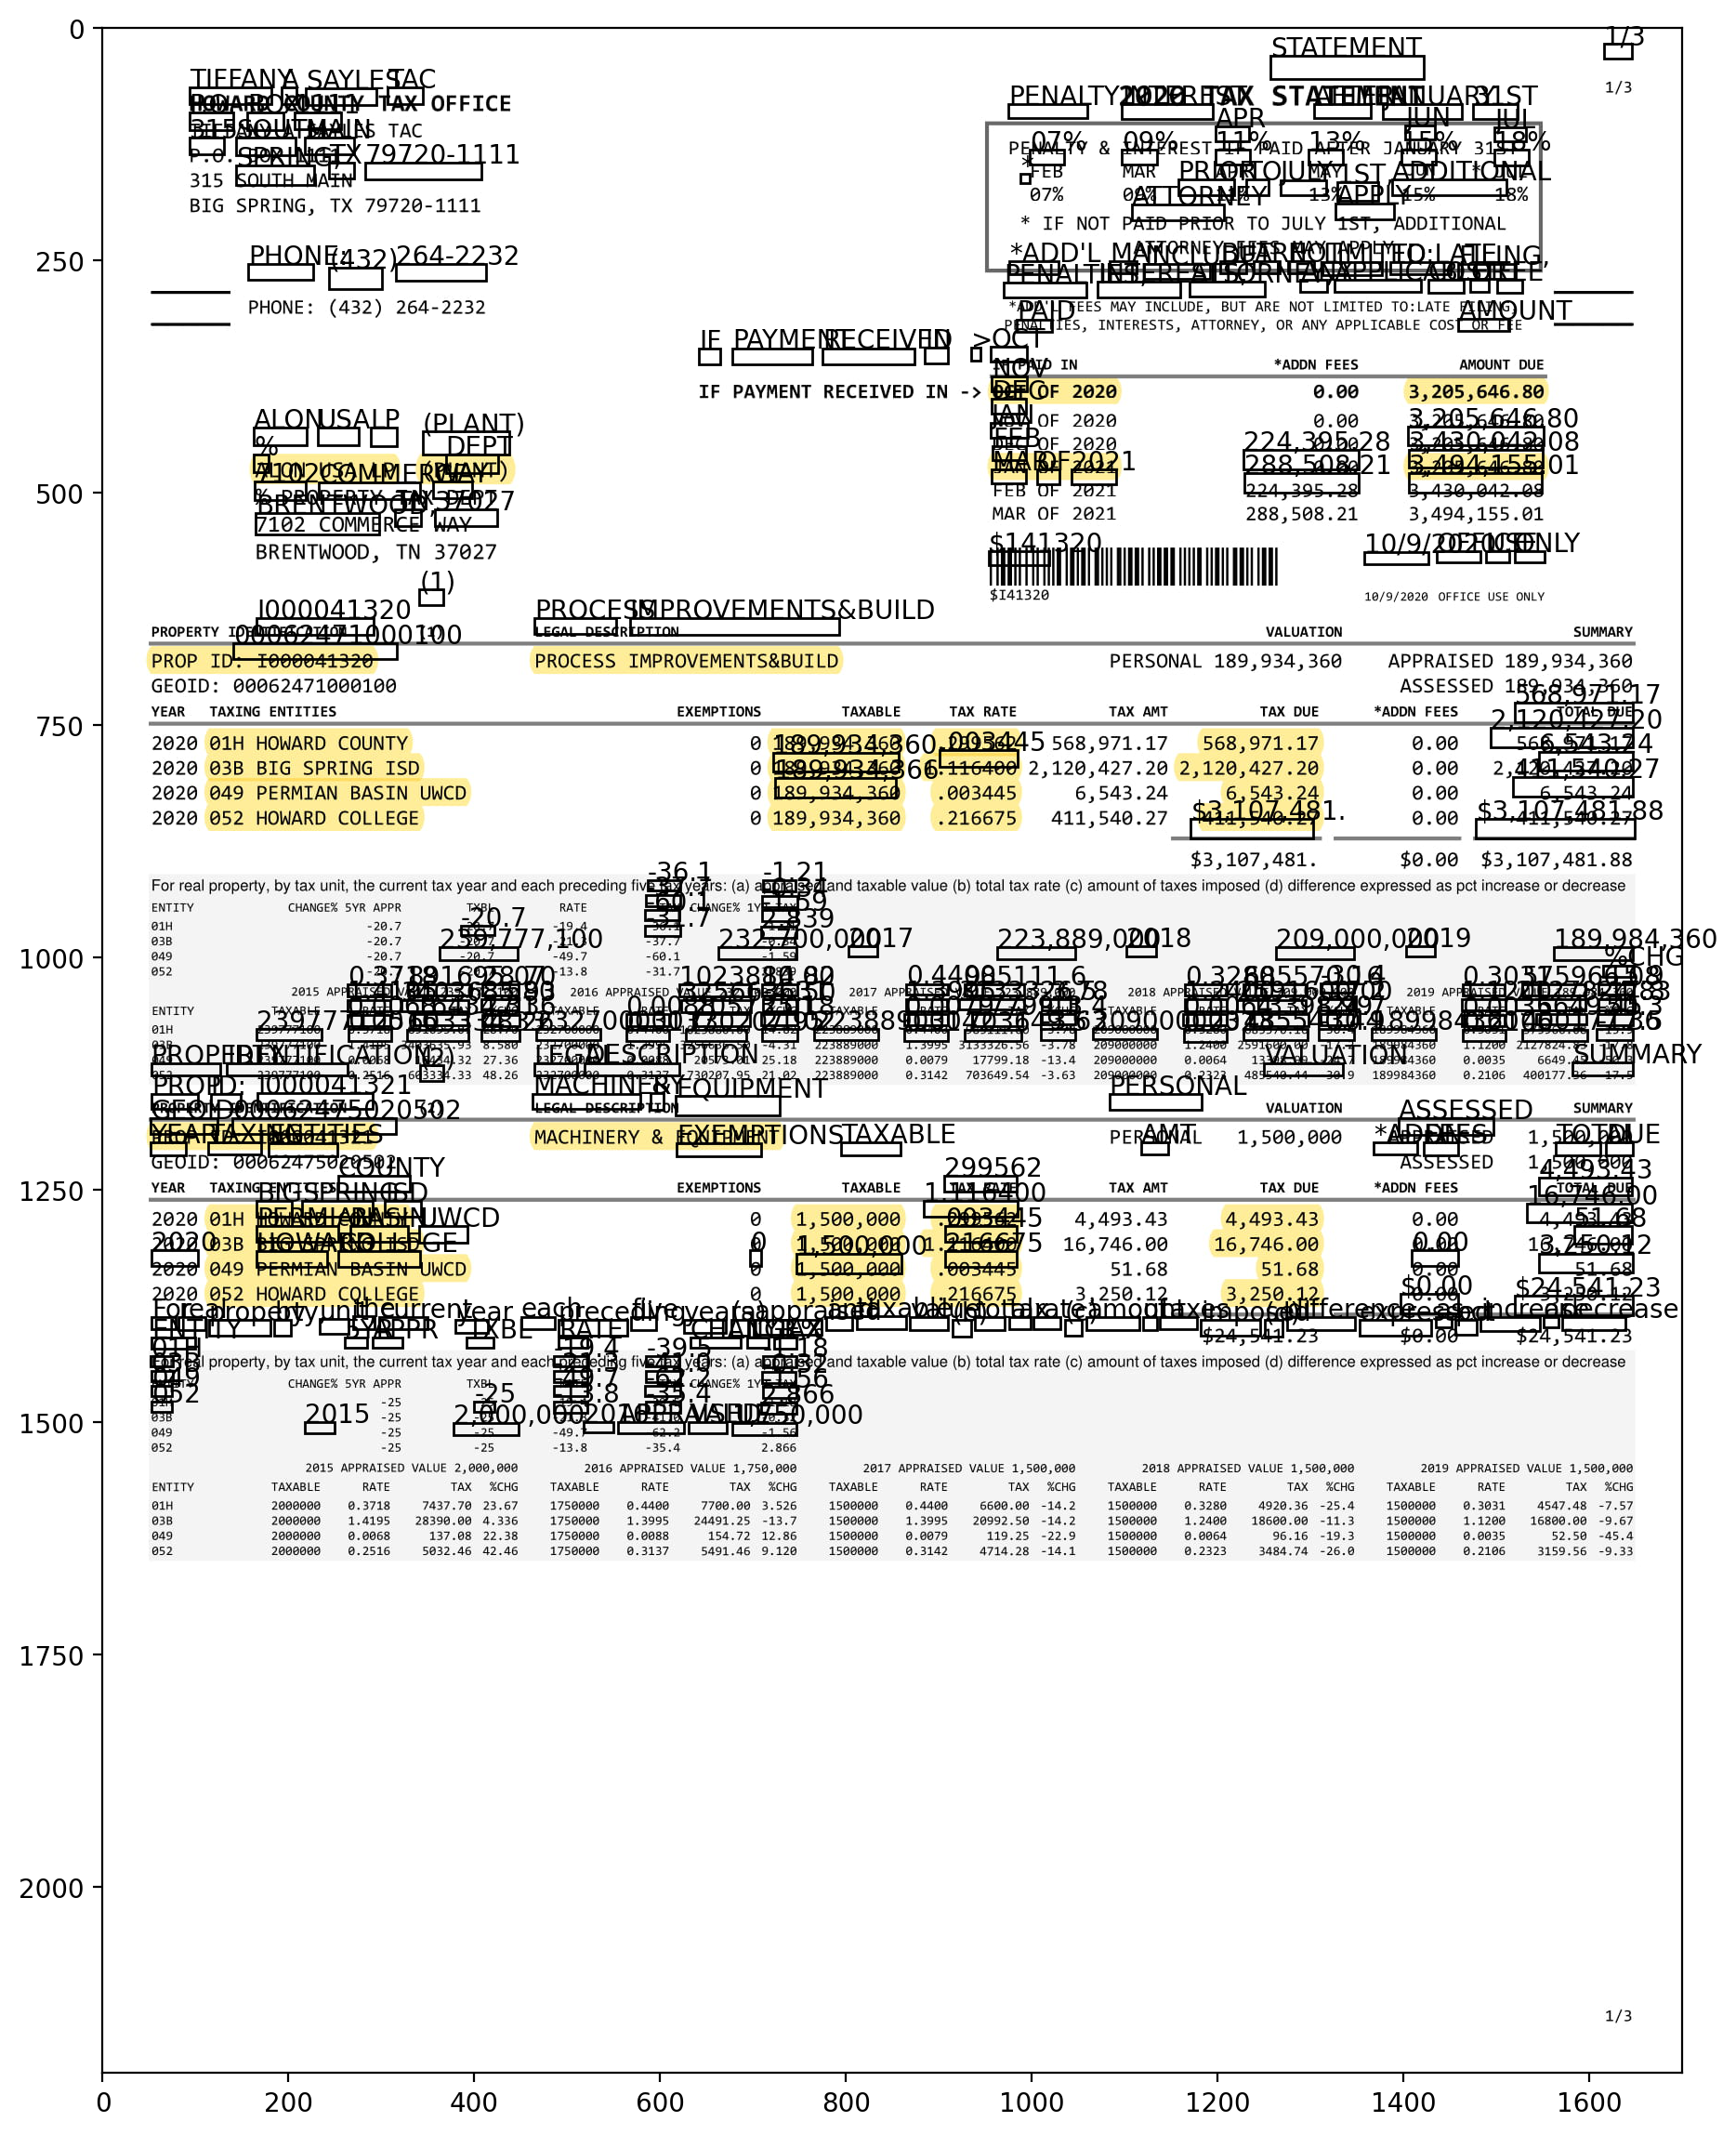

In [74]:

image=Image.open('ConvertedImages/doc_type_2-1.jpg')
plot_bounding_boxes(image,(image.size),response_output_filtered)